In [1]:
# google drive
from google.colab import drive
drive.mount('/content/drive')
dirpath = "/content/drive/MyDrive/5053/"

Mounted at /content/drive


In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN,LSTM
from keras.layers import Dropout

In [8]:
class RNNForAUD:
  def read_data(self, path):
    data = pd.read_csv(dirpath + 'AUD_v2.csv')
    data.drop(['underlyer','spot','carry','active','version'],axis=1,inplace=True)
    data = data.set_index('timestamp')
    self.series = data
    self.raw_value = self.series.values

  def preprocess(self):
    self.scaler = MinMaxScaler(feature_range = (0, 1))
    data_scaled = self.scaler.fit_transform(self.raw_value)
    # split
    # 每条样本含60个时间步，对应下一时间步的标签值
    X_train = []
    y_train = []
    for i in range(12, 5512):
        X_train.append(data_scaled[i-12:i, 0])
        y_train.append(data_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    print("X_train:",X_train.shape)
    print("y_train:",y_train.shape)
    self.X_train, self.y_train = X_train, y_train

    X_test = []
    y_test = []
    for i in range(5512, 6000):
        X_test.append(data_scaled[i-12:i, 0])
        y_test.append(data_scaled[i, 0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    print("X_test:",X_test.shape)
    print("y_test:",y_test.shape)
    self.X_test, self.y_test = X_test, y_test
  
  def train(self):
    # 初始化顺序模型
    regressor = Sequential()
    # 定义输入层及带5个神经元的隐藏层
    regressor.add(SimpleRNN(units = 5, input_shape = (self.X_train.shape[1], 1)))
    # 定义线性的输出层
    regressor.add(Dense(units = 1))
    # 模型编译：定义优化算法adam， 目标函数均方根MSE
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    # 模型训练
    self.history = regressor.fit(self.X_train, self.y_train, epochs = 100, batch_size = 100, validation_split=0.1)
    self.model = regressor

  def test(self):
    prediction = self.model.predict(self.X_test)
    prediction = self.scaler.inverse_transform(prediction)
    prediction = prediction.reshape(1,-1)[0]
    print('预测与实际差异MSE',sum(pow((prediction - self.y_test),2))/prediction.shape[0])
    print('预测与实际差异MAE',sum(abs(prediction - self.y_test))/prediction.shape[0])

In [9]:
rnn = RNNForAUD()

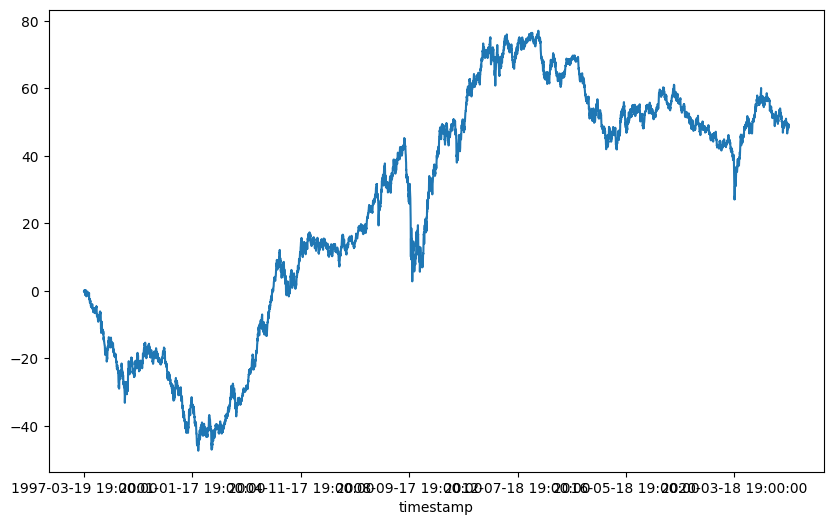

In [10]:
rnn.read_data(dirpath + 'AUD_v2.csv')

plt.figure(figsize=(10, 6))
rnn.series['tri'].plot()
plt.show()

In [11]:
rnn.preprocess()

X_train: (5500, 12, 1)
y_train: (5500,)
X_test: (488, 12, 1)
y_test: (488,)


In [13]:
rnn.train()

Epoch 1/100
50/50 [==============================] - 4s 28ms/step - loss: 0.6083 - val_loss: 0.2664
Epoch 2/100
50/50 [==============================] - 1s 11ms/step - loss: 0.0766 - val_loss: 0.0154
Epoch 3/100
50/50 [==============================] - 1s 12ms/step - loss: 0.0169 - val_loss: 0.0031
Epoch 4/100
50/50 [==============================] - 0s 8ms/step - loss: 0.0084 - val_loss: 0.0011
Epoch 5/100
50/50 [==============================] - 0s 6ms/step - loss: 0.0045 - val_loss: 2.9277e-04
Epoch 6/100
50/50 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 1.0418e-04
Epoch 7/100
50/50 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 1.7022e-04
Epoch 8/100
50/50 [==============================] - 0s 5ms/step - loss: 0.0017 - val_loss: 2.8166e-04
Epoch 9/100
50/50 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 3.4526e-04
Epoch 10/100
50/50 [==============================] - 0s 4ms/step - loss: 0.0014 - val

In [14]:
rnn.model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 5)                 35        
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


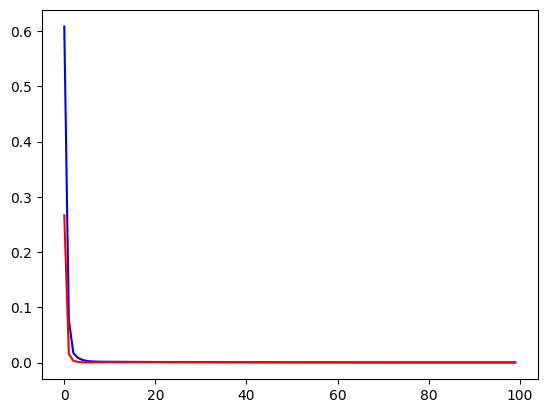

In [15]:
plt.plot(rnn.history.history['loss'],c='blue')    # 蓝色线训练集损失
plt.plot(rnn.history.history['val_loss'],c='red') # 红色线验证集损失
plt.show()

In [16]:
rnn.test()

16/16 [==============================] - 0s 2ms/step
预测与实际差异MSE 2248.467421963785
预测与实际差异MAE 47.263511857217
